In [2]:
with open('/kaggle/input/Persian-WikiText-1.txt','r') as f : 
    data = f.readlines()

In [4]:
from transformers import AutoTokenizer
from hazm import Normalizer, word_tokenize, Lemmatizer, stopwords_list
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import re

# Initialize Hazm tools
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stop_words = set(stopwords_list())

# Define regex patterns
english_word_pattern = re.compile(r'[A-Za-z]')
punctuation_pattern = re.compile(r'[^\w\s\u0600-\u06FF]')

# Load the tokenizer globally to avoid re-loading in parallel processes
tokenizer = AutoTokenizer.from_pretrained("mshojaei77/PersianBPETokenizer")
vocab = set(tokenizer.get_vocab().keys())  # Cache tokenizer vocabulary for faster lookups


def preprocess_text_single(data):
    """
    Process a single string of Persian text for normalization, tokenization, and removing unnecessary tokens.
    """
    try:
        # Normalize the text
        data = normalizer.normalize(data)

        # Tokenize the text
        tokens = word_tokenize(data)

        # Remove English words and stop words
        tokens = [token for token in tokens if not english_word_pattern.search(token)]

        # Lemmatize tokens
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        # Remove punctuation
        tokens = [token for token in tokens if not punctuation_pattern.search(token)]

        # Filter tokens using tokenizer vocabulary
        tokens = [token for token in tokens if token in vocab]

        return " ".join(tokens) if tokens else None
    except Exception as e:
        print(f"Error processing text: {e}")
        return None


def preprocess_text_parallel(data_batch, num_workers=None):
    """
    Process a batch of Persian text using multiprocessing for faster preprocessing.
    """
    num_workers = num_workers or max(1, cpu_count() - 1)  # Use all but one CPU core by default
    with Pool(processes=num_workers) as pool:
        processed_results = list(tqdm(pool.imap(preprocess_text_single, data_batch), 
                                      total=len(data_batch), desc="Preprocessing text"))
    # Remove None results (failed cases)
    return [result for result in processed_results if result is not None]


def tokenize_with_bpe(processed_corpus):
    """
    Tokenize text using the pretrained Persian BPE tokenizer.
    """
    try:
        # Encode the text with fallback for OOV tokens
        return [
            tokenizer.encode(sentence, add_special_tokens=False)
            for sentence in tqdm(processed_corpus, desc="Tokenizing with BPE")
        ]
    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None


# Example usage:
# Preprocess the corpus in parallel
print("Preprocessing text...")
processed_corpus = preprocess_text_parallel(data)

# Tokenize the preprocessed corpus
print("Using pretrained BPE tokenizer...")
tokenized_corpus = tokenize_with_bpe(processed_corpus)

if tokenized_corpus is not None:
    print("BPE Tokenization completed.")
else:
    print("BPE Tokenization failed.")


tokenizer_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.00 [00:00<?, ?B/s]

Preprocessing text...


Preprocessing text: 100%|██████████| 446023/446023 [01:57<00:00, 3799.33it/s]


Using pretrained BPE tokenizer...


Tokenizing with BPE: 100%|██████████| 208995/208995 [00:31<00:00, 6584.43it/s]

BPE Tokenization completed.


<h1>Explanation about preprocessing steps</h1>
In this preprocessing step, I decided not to remove stop words because the generated sentences seem unreadable. It is suggested to remove stop words because they are frequent in data, and the model will overfit and constantly predict them as the next token; however, in my setting, the model learns to predict them less. My preprocessing step includes removing English words, punctuation, and converting to BPE.


<h1>why we need lemmatizer</h1>

We use a lemmatizer to bring each word to its base form, which helps achieve consistency by handling different versions of a word as the same and reducing dimensionality.


<h1> How BPE works,Benefits and drawbacks</h1>

**How it Works:**
- **Step 1**: Start with a vocabulary of single characters (e.g., letters or bytes).
- **Step 2**: Identify the most frequent pair of characters in a dataset.
- **Step 3**: Merge this pair into a new "token" (e.g., combining "th" into a single token if it's frequent).
- **Step 4**: Repeat the merging process until the desired vocabulary size is reached or all frequent pairs are merged.

**Pros:**
1. **Efficient Vocabulary Size**: Creates a balance between small subword units (e.g., "t", "h") and larger words or phrases.
2. **Better Handling of Rare Words**: Breaks rare or unknown words into smaller, meaningful subwords, reducing out-of-vocabulary issues.
3. **Language Agnostic**: Can be applied to almost any language without major modification.
4. **Compact Representation**: Reduces memory usage compared to character-based models.

**Cons:**
1. **Static Vocabulary**: Once trained, the vocabulary cannot adapt dynamically to new data or tokens.
2. **Suboptimal for Morphologically Rich Languages**: Struggles with languages that have complex morphology.
3. **Merging Order Dependency**: Results depend heavily on the initial frequency distribution of tokens in the training data.
4. **Token Splitting Variability**: Different merges can cause inconsistencies in tokenization across datasets.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class NGramDataset(Dataset):
    """
    Custom PyTorch Dataset for n-gram training on tokenized data.
    """
    def __init__(self, processed_data, n=3, device="cpu"):
        """
        Args:
            processed_data (list): List of dictionaries containing 'input_ids' for each text.
            n (int): The size of the n-grams.
            device (str): The device to move tensors to ("cpu" or "cuda").
        """
        self.data = processed_data
        self.n = n
        self.device = device
        self.ngrams = self.generate_ngrams()
    
    def generate_ngrams(self):
        """
        Generate n-grams from the tokenized data.
        Returns:
            List of tuples (context, target) where:
                - context: A tensor of n-1 tokens (input).
                - target: A tensor of 1 token (output).
        """
        ngrams = []
        for tokens in self.data:
            if len(tokens) < self.n:
                continue  # Skip short sequences
            for i in range(len(tokens) - self.n + 1):
                context = tokens[i:i + self.n - 1]
                target = tokens[i + self.n - 1]
                # Move tensors to the specified device
                ngrams.append(
                    (torch.tensor(context, dtype=torch.long, device=self.device),
                     torch.tensor(target, dtype=torch.long, device=self.device))
                )
        return ngrams
    
    def __len__(self):
        return len(self.ngrams)
    
    def __getitem__(self, idx):
        return self.ngrams[idx]

# Set n-gram size
n = 10

# Initialize the dataset and ensure tensors are created on the correct device
dataset = NGramDataset(tokenized_corpus, n=n, device='cpu')

# Create DataLoader
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch
import torch.nn as nn

class NGramRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n):
        """
        Args:
            vocab_size (int): Size of the vocabulary.
            embedding_dim (int): Dimensionality of token embeddings.
            hidden_dim (int): Dimensionality of the RNN's hidden state.
            n (int): Size of n-grams (context length = n-1).
        """
        super(NGramRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  # Embedding layer
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True,num_layers=2)  # LSTM layer
        self.fc = nn.Linear(hidden_dim, vocab_size)  # Fully connected output layer

    def forward(self, x):
        """
        Forward pass through the model.
        Args:
            x (Tensor): Input tensor of shape [batch_size, seq_len].
        Returns:
            Tensor: Output logits of shape [batch_size, vocab_size].
        """
        # Step 1: Embed the input tokens
        embeds = self.embedding(x)  # Shape: [batch_size, seq_len, embedding_dim]

        # Step 2: Pass embeddings through the RNN
        out, _ = self.rnn(embeds)  # Shape: [batch_size, seq_len, hidden_dim]

        # Step 3: Use the last hidden state to predict the next token
        out = self.fc(out[:, -1, :])  # Shape: [batch_size, vocab_size]

        return out


In [ ]:
import torch

def generate_sentence(model, tokenizer, seed_text, max_len=50):
    """
    Generate a sentence using the trained model with sampling.
    Args:
        model (torch.nn.Module): The trained n-gram model.
        tokenizer: Tokenizer for encoding/decoding.
        seed_text (str): Starting sequence for sentence generation.
        max_len (int): Maximum length of the generated sequence.
    Returns:
        str: Generated sentence.
    """
    model.eval()  # Set the model to evaluation mode
    generated = seed_text
    input_ids = torch.tensor(tokenizer.encode(seed_text)).unsqueeze(0).to('cuda')
    
    with torch.no_grad():
        for _ in range(max_len):
            # Get the model's prediction
            output = model(input_ids)  # Shape: [1, vocab_size]
            probabilities = torch.softmax(output, dim=-1).squeeze(0)  # Convert logits to probabilities
            
            # Sample a token from the probability distribution
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()
            
            # Append the predicted token to the sequence
            generated += tokenizer.decode([next_token_id])+' '
            # Update input_ids for the next prediction
            input_ids = torch.cat((input_ids[:, 1:], torch.tensor([[next_token_id]], device='cuda')), dim=1)

    return generated


In [ ]:
import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Hyperparameters
epochs = 15
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize model
model = NGramRNN(vocab_size=30000, embedding_dim=512, hidden_dim=64, n=10).to(device)

#model.load_state_dict(torch.load('/kaggle/working/model_epoch_5.pth', weights_only=True))

# Initialize optimizer and scheduler
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Loss progression tracker
loss_progression = []


# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    # Initialize progress bar for the epoch
    with tqdm(total=len(dataloader) // 500, desc=f"Epoch {epoch + 1}/{epochs}", unit="update", dynamic_ncols=True) as pbar:
        for i, (contexts, targets) in enumerate(dataloader):
            # Move data to device
            contexts, targets = contexts.to(device), targets.to(device)

            # Forward pass
            outputs = model(contexts)
            loss = criterion(outputs, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Update progress bar only every 500 batches
            if (i + 1) % 500 == 0:
                avg_loss = total_loss / (i + 1)
                pbar.set_postfix({"Avg Loss": f"{avg_loss:.4f}"})
                pbar.update(1)  # Increment progress bar by 1

    # Update learning rate scheduler
    scheduler.step()

    # Log average loss
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg Loss: {avg_loss:.4f}")

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model_save_path = f"model_epoch_{epoch + 1}.pth"
        try:
            torch.save(model.state_dict(), model_save_path)
            print(f"Model saved successfully at {model_save_path}")
        except Exception as e:
            print(f"Error saving model at epoch {epoch + 1}: {e}")

    # Generate a sample sentence after the epoch
    seed_text = 'مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست'
    try:
        generated_sentence = generate_sentence(model, tokenizer, seed_text, max_len=50)
        print("\nGenerated Sentence:")
        print(generated_sentence)
        print("\nOriginal Sentence:")
        print(seed_text)
    except Exception as e:
        print(f"Error generating sentence: {e}")


In [ ]:
import matplotlib.pyplot as plt

# Plot loss progression
plt.figure(figsize=(8, 6))
plt.plot(range(1, 15 + 1), loss_progression, marker='o', linestyle='-', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Progression Over Epochs")
plt.legend()
plt.grid()
plt.show()

<h1>Transformer Implementation</h1>

In [5]:
import torch 
from torch.nn import functional as F
from torch import nn

import math 



class LayerNorm(nn.Module) : 

    def __init__(self,embed_dim,ep=1e-5) : 

        """
        defines LayerNormalizer.

        Args : 
            embed_dim (int) : determine size of embedding . 
        """
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(embed_dim)) 
        self.beta = nn.Parameter(torch.zeros(embed_dim))
        self.ep = ep

    def forward(self,x) : 

        """
        applies LayerNormalization to x.

        Returns (torch.Tensor) : Layer Normalized tensor.
        """

        mu = torch.mean(x,axis=-1).unsqueeze(-1)
        var = torch.var(x,axis=-1,unbiased=False).unsqueeze(-1)
        normalized_x = (x-mu)/torch.sqrt(var+self.ep)
        output = self.gamma * normalized_x + self.beta
        return output
    
class InputEmbedding(nn.Module) : 

    """
    Calculates a continuous representation for each token in the vocabulary using embeddings.

    This function generates embeddings that transform BPE encoded categorical token representations into dense vectors.

    Args:
        vocab_size (int): The number of unique tokens in the vocabulary. Determines the number of rows in the embedding matrix.
        d_model (int): The dimensionality of the embedding vectors. Each token will be represented as a vector of this size.
    """

    def __init__(self,vocab_size,embed_dim) : 
        super(InputEmbedding, self).__init__()
        self.d_model = embed_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
    
    def forward(self,x) : 
        """
        computes input embedding for certain sequence of vocalbularies.
        
        Args : 
            x (Torch.tensor) : sequence of tokens.

        Returns : 
            (Torch.tensor) : embedded representation of input sequence of shape (batch_size, seq_len, embedding_dim).
        """
        return self.embedding(x) * math.sqrt(self.d_model)



class PositionalEncoding(nn.Module):

    """
    Computes postional embedding vectores for embedded sequence
    
    Args : 
        embed_dim : dimension of embedding
        seq_len :  length of sequence

    """

    def __init__(self, embed_dim, seq_len):
        super().__init__()
        self.embed_dim = embed_dim
        self.seq_len = seq_len
        position = torch.arange(0, seq_len).unsqueeze(1).float()  
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_dim))

        pe = torch.zeros(seq_len, embed_dim) 
        pe[:, 0::2] = torch.sin(position * div_term)  # Even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd dimensions

        # Add a batch dimension and register as a buffer
        pe = pe.unsqueeze(0)  # Shape: (1, seq_len, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Adds up positional embedding vectore to input sequence.

        Returns (Torch.tensor) : positional embedded representation of input sequence of shape (batch_size, seq_len, embedding_dim).
        """
        return x + self.pe[:, :x.shape[1], :].requires_grad_(False)


class MultiHeadAttention(nn.Module) : 


    def __init__(self,embed_dim,seq_len,num_heads,masked=False):

        """
        Multi Head Attention Mechanism
        Args : 
        embed_dim (int) : dimension of embeded representation of each element in sequence.
        seq_len (int) : length of sequence
        num_heads (int) : number of attention heads
        """
        super().__init__()
        self.d_model ,self.seq_len = embed_dim , seq_len
        self.num_heads = num_heads
        self.head_dim = self.d_model // self.num_heads
        self.masked = masked
        self.Q_proj = nn.Linear(self.d_model,self.d_model)
        self.K_proj = nn.Linear(self.d_model,self.d_model)
        self.V_proj = nn.Linear(self.d_model,self.d_model)
        self.Out_proj = nn.Linear(self.d_model,self.d_model)
        if masked : 
            mask = torch.tril(torch.ones(seq_len,seq_len)).float()
            self.register_buffer('mask',mask)


    def LinearTransform(self,K,Q,V) : 

        """
        Applies Linear transformation on key,query and value matrices

        Args : 

        K (torch.tensor) : Key 
        Q (torch.tensor) : Query 
        V (torch.tensor) : Value

        Returns : 
            Linear projected Key, Query and value tensor.
        """

        K = self.K_proj(K)
        Q = self.Q_proj(Q)
        V = self.V_proj(V)
        return K,Q,V

    def Attention(self,K,Q,V) : 

        """
        Applies Attention Mechanism on projected Key, Query and Value matrices
        
        Returns : 
            attention heads (torch.tensor) : tensor of shape (batch_size,num_heads,head_dim) containing attention heads.
            attention table (torch.tensor) : tensor of shape (batch_size,num_heads,seq_len,seq_len)
            
        """
        attention_table = torch.matmul(Q,K.permute(0,1,3,2))/math.sqrt(self.head_dim) #(batch_size,num_heads,seq_length,seq_length)
        attention_table = F.softmax(attention_table,dim=-1)
        if self.masked : 
            attention_table = attention_table * self.mask
        attention_heads = torch.matmul(attention_table,V)

        return attention_heads,attention_table
    

    def MultiHeadAttention(self,K,Q,V) : 

        """
        K : Tensor of shape : (batch_size,seq_len,d_model)
        Q : Tensor of shape : (batch_size,seq_len,d_model)
        V : Tensor of shape : (batch_size,seq_len,d_model)
        
        Return : 
            Attention table of shape : (batch_size,seq_length,seq_length)
            Concatenated Attention heads of shape : (batch_size,seq_length,d_model)
        """

        batch_size = K.shape[0]
        Q_split = Q.permute(0,2,1).view(batch_size,self.num_heads,self.head_dim,self.seq_len).permute(0,1,3,2) #(batch_size,num_heads,seq_length,head_dim)
        K_split = K.permute(0,2,1).view(batch_size,self.num_heads,self.head_dim,self.seq_len).permute(0,1,3,2) 
        V_split = V.permute(0,2,1).view(batch_size,self.num_heads,self.head_dim,self.seq_len).permute(0,1,3,2)
        attention_heads , attention_table = self.Attention(K_split,Q_split,V_split)
        attention_heads = attention_heads.permute(0,2,1,3).reshape(batch_size,self.seq_len,self.num_heads*self.head_dim)
        return attention_heads,attention_table
        

    def forward(self,K,Q,V) : 
        
        """
        takes K,Q,V and applies MultiHeadAttention mechanism.
        
        Returns : 
            attention heads (torch.tensor) : tensor of shape (batch_size,seq_length,d_model) containing attention heads.
            attention table (torch.tensor) : tensor of shape (batch_size,num_heads,seq_len,seq_len)
        """

        K,Q,V = self.LinearTransform(K,Q,V)
        attention_head , attention_table = self.MultiHeadAttention(K,Q,V)
        attention_head = self.Out_proj(attention_head)
        return attention_head,attention_table

class FeedForward(nn.Module):
    def __init__(self, embed_dim, ff_dim=2048):  
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_dim, ff_dim)  
        self.fc2 = nn.Linear(ff_dim, embed_dim)  
        self.dropout = nn.Dropout(0.1) 

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))

class Encoder(nn.Module) :

    """
    Encoder part of transformers.
    """

    def __init__(self,embed_dim,seq_len,num_heads,vocab_size) : 

        """
            Encoder part of transformers.
            Args : 
                embed_dim (int) : embedding dimension of the input sequence.
                seq_len (int) : length of input sequence.
                num_heads (int) : number of attention heads.
                vocab_size (int) : maximum number of tokens in vocabulary.
        """
        super(Encoder,self).__init__()
        self.InputEmbedder = InputEmbedding(vocab_size=vocab_size,embed_dim=embed_dim)
        self.PosEmbedder = PositionalEncoding(embed_dim=embed_dim,seq_len=seq_len)
        self.MultiHeadAttention = MultiHeadAttention(embed_dim=embed_dim,seq_len=seq_len,num_heads=num_heads)
        self.FeedForward = nn.Linear(seq_len,seq_len)
        self.LayerNormalizerMultiHead = LayerNorm(embed_dim)
        self.LayerNormalizerOut = LayerNorm(embed_dim)

    def forward(self,x) : 
        """
            Computes operations on single layer of Encoder in transformer.
            Args : 
                x (torch.Tensor) : input sequence of shape (batch_size,1,seq_len) 
            
            Returns : 
                torch.Tensor (batch_size,seq_length,embed_dim) 

        """
        input_embedded = self.PosEmbedder(self.InputEmbedder(x))
        x = self.MultiHeadAttention(K=input_embedded,Q=input_embedded,V=input_embedded)
        AttentionNormalized = self.LayerNormalizerMultiHead(input_embedded + x)
        x = self.FeedForward(AttentionNormalized)
        x = F.relu(x)
        x = self.LayerNormalizerOut(x + AttentionNormalized)
        return x


class Decoder(nn.Module) : 

    def __init__(self,embed_dim,seq_len,num_heads,vocab_size) : 
        super(Decoder,self).__init__()
        self.InputEmbedder = InputEmbedding(vocab_size=vocab_size,embed_dim=embed_dim)
        self.PosEmbedder = PositionalEncoding(embed_dim=embed_dim,seq_len=seq_len)
        self.MaskedMultiHeadAttention = MultiHeadAttention(embed_dim=embed_dim,seq_len=seq_len,num_heads=num_heads,masked=True)
        self.MultiHeadAttention= MultiHeadAttention(embed_dim=embed_dim,seq_len=seq_len,num_heads=num_heads)
        self.LayerNormalizerMaskedAttention = LayerNorm(embed_dim)
        self.LayerNormalizerCrossAttention = LayerNorm(embed_dim)
        self.LayerNormalizerOut = LayerNorm(embed_dim)
        self.FeedForward = nn.Linear(embed_dim,embed_dim)
    
    def forward(self,x,EncoderOut='self') : 
        input_embedded = self.InputEmbedder(x)
        input_embedded = self.PosEmbedder(input_embedded)
        x , _ = self.MultiHeadAttention(input_embedded,input_embedded,input_embedded)
        AttentionNormalized = self.LayerNormalizerMaskedAttention(input_embedded + x)
        if EncoderOut == 'self' : 
            CrossAttention, _ = self.MultiHeadAttention(AttentionNormalized,AttentionNormalized,AttentionNormalized)
        CrossAttentionNormalized = self.LayerNormalizerCrossAttention(CrossAttention + AttentionNormalized)
        x = self.FeedForward(CrossAttentionNormalized)
        x = F.relu(x)
        x = self.LayerNormalizerOut(x + CrossAttentionNormalized)
        return x



class NGram(nn.Module) : 

    def __init__(self,embed_dim,seq_len,num_heads,vocab_size) :
        super(NGram,self).__init__()
        self.Decoder = Decoder(embed_dim=embed_dim,seq_len=seq_len,num_heads=num_heads,vocab_size=vocab_size)
        self.linear = nn.Linear(embed_dim,embed_dim)
    
    def forward(self,x) : 
        x = self.Decoder(x)
        x = self.linear(x) #(batch_size,seq_length,vocab_size)
        
        x = F.log_softmax(x,dim=-1)
        return x


class NGramSingleStep(nn.Module):
    def __init__(self, embed_dim, seq_len, num_heads, vocab_size):
        super(NGramSingleStep, self).__init__()
        self.Decoder1 = Decoder(embed_dim=embed_dim, seq_len=seq_len, num_heads=num_heads, vocab_size=vocab_size)
        self.Decoder2 = Decoder(embed_dim=embed_dim, seq_len=seq_len, num_heads=num_heads, vocab_size=vocab_size)

        self.linear = nn.Linear(embed_dim, vocab_size)  # Output now maps to vocab size for single-token prediction

    def forward(self, x, prev_tokens=None):
        """
        Predict the next token given the current context.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len)
            prev_tokens (torch.Tensor, optional): Previously generated tokens, for autoregressive generation.
            
        Returns:
            torch.Tensor: Log probabilities for the next token.
        """
        if prev_tokens is not None:
            # Concatenate previous tokens with the current input
            x = torch.cat((prev_tokens, x), dim=1)

        # Pass through the Decoder
        decoder_output = self.Decoder1(x)
        decoder_output = self.Decoder2(x)
        
        # Take the last time step's output for prediction
        last_token_output = decoder_output[:, -1, :]  # Shape: (batch_size, embed_dim)
        
        # Project to vocab size and apply log softmax
        logits = self.linear(last_token_output)  # Shape: (batch_size, vocab_size)
        log_probs = F.log_softmax(logits, dim=-1)
        return log_probs



        


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class NGramDataset(Dataset):
    """
    Custom PyTorch Dataset for n-gram training on tokenized data.
    Each n-gram instance (context, target) will be padded to a fixed length (max_seq).
    """
    def __init__(self, processed_data, n=3, device="cpu", max_seq=64):
        """
        Args:
            processed_data (list): List of dictionaries containing 'input_ids' for each text.
            n (int): The size of the n-grams.
            device (str): The device to move tensors to ("cpu" or "cuda").
            max_seq (int): The target length to pad context and target tensors to.
        """
        self.data = processed_data
        self.n = n
        self.device = device
        self.max_seq = max_seq
        self.ngrams = self.generate_ngrams()
    
    def generate_ngrams(self):
        """
        Generate n-grams from the tokenized data.
        Returns:
            List of tuples (context, target) where:
                - context: A tensor of n-1 tokens (input).
                - target: A tensor of 1 token (output).
        """
        ngrams = []
        for tokens in self.data:
            if len(tokens) < self.n:
                continue  # Skip short sequences
            for i in range(len(tokens) - self.n + 1):
                context = tokens[i:i + self.n - 1]
                target = tokens[i + self.n - 1]
                
                # Pad context and target to max_seq length
                context_padded = self.pad_tensor(torch.tensor(context, dtype=torch.long, device=self.device))
                target_padded = torch.tensor([target], dtype=torch.long, device=self.device)
                
                ngrams.append((context_padded, target_padded))
        return ngrams
    
    def pad_tensor(self, tensor):
        """
        Pads a tensor to the max_seq length.
        If the tensor is shorter than max_seq, it will be padded with 0s.
        """
        padding_length = self.max_seq - tensor.size(0)
        if padding_length > 0:
            # Pad the tensor with 0s on the right
            return F.pad(tensor, (0, padding_length), value=0)
        else:
            return tensor[:self.max_seq]  # If the tensor is already longer than max_seq, truncate it
    
    def __len__(self):
        return len(self.ngrams)
    
    def __getitem__(self, idx):
        return self.ngrams[idx]

# Set n-gram size
n = 8

# Initialize the dataset and ensure tensors are created on the correct device
dataset = NGramDataset(tokenized_corpus, n=n, device='cpu')

# Create DataLoader


In [7]:
import torch

def generate_sentence(model, tokenizer, seed_text,max_len):
    """
    Generate a sentence using the trained model with sampling.
    Args:
        model (torch.nn.Module): The trained n-gram model.
        tokenizer: Tokenizer for encoding/decoding.
        seed_text (str): Starting sequence for sentence generation.
        max_len (int): Maximum length of the generated sequence.
    Returns:
        str: Generated sentence.
    """
    model.eval()  # Set the model to evaluation mode
    generated = seed_text
    model_input = torch.zeros((1,64),dtype=torch.long).to('cuda')
    input_ids = torch.tensor(tokenizer.encode(seed_text))
    model_input[0,0:len(input_ids)] = input_ids
    input_length = len(input_ids)
    with torch.no_grad():
        for _ in range(max_len-input_length):
            # Get the model's prediction
            output = model(model_input)  # Shape: [1, vocab_size]
            probabilities = torch.softmax(output, dim=-1).squeeze(0)  # Convert logits to probabilities
            
            # Sample a token from the probability distribution
            next_token_id = torch.multinomial(probabilities, num_samples=1).item()
            
            # Append the predicted token to the sequence
            generated += ' '+tokenizer.decode([next_token_id])
            # Update input_ids for the next prediction
            input_ids = torch.cat((model_input[:, 1:], torch.tensor([[next_token_id]], device='cuda')), dim=1)

    return generated


In [13]:
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Training Hyperparameters
LEARNING_RATE = 0.01
NUM_EPOCHS = 15
device = 'cuda'

# Model, Loss, Optimizer, and Scheduler
model = NGramSingleStep(embed_dim=512, seq_len=64, num_heads=8, vocab_size=30000).to(device)
criterion = nn.NLLLoss()  # Works because the model outputs log probabilities
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# Track training loss
epoch_losses = []
batch_losses = []

# Seed text for evaluation
seed_text = 'مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست'

# Training Loop
model.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    with tqdm(dataloader, desc=f"Training Progress [Epoch {epoch + 1}]", leave=True) as progress_bar:
        batch_counter = 0
        running_loss = 0  # Running loss for every batch group
        for batch_idx, (contexts, targets) in enumerate(progress_bar):
            contexts, targets = contexts.to(device), targets.to(device)

            optimizer.zero_grad()

            log_probs = model(contexts)
            loss = criterion(log_probs, targets.squeeze())  # Compute loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            batch_counter += 1

            # Append loss every 20 batches
            if batch_counter % 20 == 0:
                batch_losses.append(running_loss / 20)  # Append the average loss for the last 20 batches
                running_loss = 0  # Reset running loss

            progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})

    avg_loss = epoch_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}")

    print(generate_sentence(model, tokenizer, seed_text, 64))

    scheduler.step(avg_loss)

    model_save_path = f"ngram_model_epoch{epoch + 1}.pth"
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

# Plotting the Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(batch_losses) + 1), batch_losses, marker='o')
plt.xlabel("Batch Iteration (every 20 batches)")
plt.ylabel("Average Loss")
plt.title("Batch Loss Progression (every 20 batches)")
plt.grid()
plt.show()


Epoch 1/15 - Current LR: 0.010000


Training Progress [Epoch 1]: 100%|██████████| 13722/13722 [1:05:58<00:00,  3.47it/s, Batch Loss=6.6660]


Epoch 1 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست در تقلب جستجوی تالار مرکز مسیحی تلاش باستان منجر فارسی است و بر نیاز برای خبره زی جزیره اهم یعنی است به از شش استفاده قله از بر همه را ، برای گام بار کشور را که جراحی
Model saved to ngram_model_epoch1.pth
Epoch 2/15 - Current LR: 0.010000


Training Progress [Epoch 2]: 100%|██████████| 13722/13722 [1:05:51<00:00,  3.47it/s, Batch Loss=6.3007]


Epoch 2 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست و باره حکم مردمان به وقت یکدیگر هم از بوته خانه کیا ثابت در گوناگون از بیرونی روز از هر به را که جلب دنبال و ، شب جداگانه طرف انسان زمان به را اثبات درختان نام زیر
Model saved to ngram_model_epoch2.pth
Epoch 3/15 - Current LR: 0.010000


Training Progress [Epoch 3]: 100%|██████████| 13722/13722 [1:05:50<00:00,  3.47it/s, Batch Loss=6.7482]


Epoch 3 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست طرف نتیجه و این که زمینه و قرار خاطر خود و منصفانه هندسه نزدیکی کامپیوتر دوره شیء و کنترل اندیشه که بیاورد دانشگاه از و در از اتفاق به پنجاه این چرخاندن گودال نقش تا نیروی گروه به
Model saved to ngram_model_epoch3.pth
Epoch 4/15 - Current LR: 0.001000


Training Progress [Epoch 4]: 100%|██████████| 13722/13722 [1:05:47<00:00,  3.48it/s, Batch Loss=6.3195]


Epoch 4 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست عمل به جنگ دهه فساد از پی ایران کوتاه زمینه تاریخی نهایت بعدها ساختار با دور بی را شهرداری همراه در را این شش تشکیل حساب اول متفاوت چهار خورشیدی را زیر بر دیگر از فعالیت سایر از
Model saved to ngram_model_epoch4.pth
Epoch 5/15 - Current LR: 0.001000


Training Progress [Epoch 5]: 100%|██████████| 13722/13722 [1:05:47<00:00,  3.48it/s, Batch Loss=6.5462]


Epoch 5 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست که گروه دیگر در گچ مدت برنامه ، پیشرفت دو که ما درخت ماه ، هم ماشین بدون به یک با نمود نقش در را از بر به ، گروهی از از دریافت بابل یا یک در حدود
Model saved to ngram_model_epoch5.pth
Epoch 6/15 - Current LR: 0.000100


Training Progress [Epoch 6]: 100%|██████████| 13722/13722 [1:05:48<00:00,  3.48it/s, Batch Loss=5.8731]


Epoch 6 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست دو و تحقیقات اثر چه درصد سابقه در مراسم بهترین مشهور روز مدرسه بیش لی بررسی فرم از که و که است اصلی کور البته بلوغ بین سیاسی کنسرت با در ارکستر و حال که از را به
Model saved to ngram_model_epoch6.pth
Epoch 7/15 - Current LR: 0.000100


Training Progress [Epoch 7]: 100%|██████████| 13722/13722 [1:05:48<00:00,  3.47it/s, Batch Loss=6.9562]


Epoch 7 Loss: 0.0000
مقاله مشترک استیون هاوکینگ و پنروز که در سال ۱۹۷۰ منتشر و ثابت که اگر نسبیت عام درست درهم همان رخ فیلم در فیلم نزدیک مدرن از برق سرتاسر رد دچار سینما نفی به میلادی ایتالیا نسبتا در کنسرت مورد از ده خودش در ظاهرا هم به از مهم که رمان گذشته جدول مشهور ، فیلم
Model saved to ngram_model_epoch7.pth
Epoch 8/15 - Current LR: 0.000010


Training Progress [Epoch 8]:   0%|          | 41/13722 [00:12<1:10:53,  3.22it/s, Batch Loss=6.0556]


KeyboardInterrupt: 

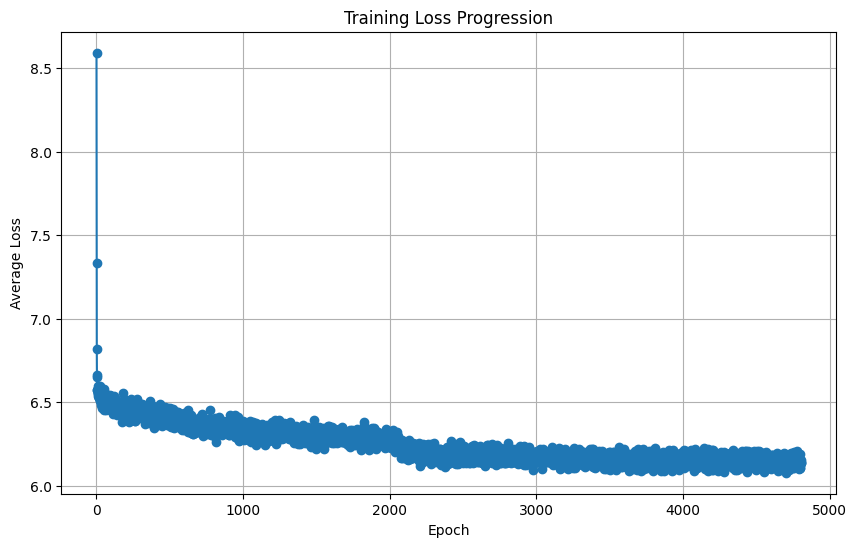

In [17]:

# Plot loss progression
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(batch_losses)+1), batch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss Progression")
plt.grid()
plt.show()
